# <font size = "7"> **Projet Pizzo Topping - MI201**

MOREL, GUINOT et MSSELLATI





L'objectif de ce projet est de d'établir une prédiction sur la présence ou non d'une garniture sur la photo d'une pizza. En premier lieu, nous avons travaillé sur un dataset composé d'images synthétiques, plus faciles à manipuler. Nous n'avons pas eu le temps de travailler sur les images réelles de pizza.

Pour la détection de nos garnitures, nous avons mis en place des modèles de machine learning répartis en trois catégories :

- par initialisation aléatoire (from scratch sur un CNN)
- par extraction de caractéristiques (features extraction)
- par ajustement de réseau pré-appris (fine-tuning)

Si les cases sont compilées dans l'ordre, il n'y aura normalement pas de problèmes de réafectation de variables malencontreuses.
Il faut néanmoins modifier la valeur de *input_size* à 32 au lieu de 64 si vous voulez utiliser le réseau *SimpleCNN*. Cette variable ce trouve ici : "*1 - Preparation for working on ML models//Data loader AND PARAMETERS*"

Un dossier model est également fourni avec le notebook au cas où il est impossible de recréer ces modèles en les lançant dans ce dernier.

BONNE LECTURE.

 

##<font size = "7"> 1 - Preparation for working on ML models

### Importation of libraries

In [20]:
##Bibliotheque utiles dans tous le notebook

#Datapath TAO
from google.colab import drive
drive.mount('/content/gdrive/')
DATA_DIR =  '/content/gdrive/MyDrive/ProjectMI201'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [21]:
from torchvision.ops.feature_pyramid_network import OrderedDict
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

from collections import OrderedDict


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
    !nvidia-smi

In [ ]:
print(torch.cuda.is_available())

False


### Read Data

In [78]:
#This method returns a Boolean value of class bool. This method returns True if path exists otherwise returns False.
print('the path '+'\''+DATA_DIR+ '/syntheticDataset/train/trainLabels.txt\' exists :', os.path.exists(DATA_DIR+ '/syntheticDataset/train/trainLabels.txt'))  
print('the path '+'\''+DATA_DIR+ '\' exists :', os.path.exists(DATA_DIR))  

y_all = np.loadtxt(DATA_DIR + '/syntheticDataset/train/trainLabels.txt')
x_all = np.arange(y_all.shape[0]) # x_all = [id1, id2, ...] = [0,1,..., y_all.shape[0]-1]


# Create train, val and test splits
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

y_test = np.loadtxt(DATA_DIR + '/syntheticDataset/test/testLabels.txt')
x_test = np.arange(y_test.shape[0])



the path '/content/gdrive/MyDrive/ProjectMI201/syntheticDataset/train/trainLabels.txt' exists : True
the path '/content/gdrive/MyDrive/ProjectMI201' exists : True


###Utils

In [27]:
#gobal variables :
list_toppings = ["Chorizo","Champignon","Poivron","Olive","Basilic", "Bacon", "Brocoli", "Ananas", "Tomate", "Oignon"]
nlabel = 10

Useful Functions :

In [28]:
## Useful Funcitons
def plot_loss_results(train_losses, val_losses, train_perf, val_perf):

  plt.figure(figsize=(15,5))
  plt.title("LOSS")
  plt.plot(train_losses, label='train loss')
  plt.plot(val_losses, label='val loss')
  plt.legend()

  plt.figure(figsize=(15,5))
  plt.title("TRAIN")
  for k in range(len(train_perf)):
    plt.plot(list_toppings,train_perf[k]*100)
  plt.legend()

  plt.figure(figsize=(15,5))
  plt.title("VAL")
  plt.bar(list_toppings,val_perf[-1]*100)

In [29]:
def Test(model, testloader):

  # set the model to evaluation mode
  model.eval()

  # create the perf list
  perf_label_test = np.zeros((1,nlabel))

  # tell not to reserve memory space for gradients (much faster)
  with torch.no_grad():
      for inputs, targets in tqdm(testloader, ncols=80):

          inputs = inputs.to(device)
          targets = targets.to(device)

          # compute outputs
          outputs = model(inputs)

          outputs_np = outputs.cpu().detach().numpy()
          targets_np = targets.cpu().detach().numpy()

          # compute the predictions
          pred = (outputs_np > 0)

          # update the performance
          perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

    # Prints the performance (per label)

  oa_test = perf_label_test / len(testloader.dataset)

  print("Pourcentage de bonnes prédictons par topping : ", oa_test[0])
  print("Moyenne des prédictions : ", oa_test.mean())


  plt.figure(figsize = (15, 5))
  plt.title("TEST (en pourcentage de bonnes predictions)")
  plt.bar(list_toppings,oa_test[0]*100, width=0.8)

Training function

In [30]:
#from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import random
import copy

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=5):

    #optimizer.zero_grad()
    # list for saving accuracies
    train_perf = []
    val_perf = []
    train_losses = []
    val_losses = []

    # if Sigmoid not used in the last layer of the network: 0, else, 0.5
    rate = 0
    total_step = len(valloader)
    
    # iterate over epochs
    for epoch in range(num_epochs):
      print("-------------- Epoch {}".format(epoch+1),"/",num_epochs," ------------\n")

      #Tells the model that we are evaluation
      model.train()
      train_perf_for_epoch = np.zeros((1,nlabel))



      # ----------------------------------------------------TRAINING LOOP-----------------------------------------------------
      losses = []
      for inputs, targets in tqdm(trainloader):
          inputs = inputs.to(device)
          targets = targets.to(device)#.to(torch.float32)
  
          outputs = model(inputs)#.to(torch.float32)

          #if model == networkCNN | model == efficientNet:
          outputs = outputs.to(torch.float32)
          targets = targets.to(torch.float32)

          loss = criterion(outputs,targets)
          losses.append(loss.item())

          loss.backward()

          optimizer.step()
          optimizer.zero_grad()

          outputs_np = outputs.cpu().detach().numpy()
          targets_np = targets.cpu().detach().numpy()

          pred = (outputs_np > rate)

          train_perf_for_epoch = train_perf_for_epoch + (targets_np == pred).sum(axis=0)

      train_perf.append(train_perf_for_epoch[0]/ len(trainloader.dataset))
      train_losses.append(losses[-2])
      for param_group in optimizer.param_groups:
        print("learning rate : ", param_group['lr'])
      print("\nTrain perf mean: ", train_perf[-1].mean(),"\n")

      if scheduler != None:
            scheduler.step()


        
      # ----------------------------------------------- VALIDATION LOOP -----------------------------------------------------
      val_perf_for_epoch = np.zeros((1,nlabel))

      model.eval()
      with torch.no_grad():
        losses = []
        for inputs, targets in tqdm(valloader):
          inputs = inputs.to(device)
          targets = targets.to(device)

          outputs = model(inputs)

          #if model == networkCNN:
          outputs = outputs.to(torch.float32)
          targets = targets.to(torch.float32)
            
          loss_val = criterion(outputs, targets)

          losses.append(loss_val.item())
        


          outputs_np = outputs.cpu().detach().numpy()
          targets_np = targets.cpu().detach().numpy()

          pred = (outputs_np > rate)

          val_perf_for_epoch = val_perf_for_epoch + (targets_np == pred).sum(axis=0)


      val_perf.append(val_perf_for_epoch[0]/ len(valloader.dataset))
      print("\nval loss:", losses[-2])
      val_losses.append(losses[-2])
      print("\nTest perf mean: ", val_perf[-1].mean(),"\n")

      print("\n\n")

              
    return model, train_perf, val_perf,  train_losses, val_losses

### Stores train and test image in memories

In [24]:
train_data_path = os.path.join(DATA_DIR, 'syntheticDataset/train')

# Test if the numpy file exists
if (os.path.exists(os.path.join(train_data_path, 'img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(train_data_path, 'img_data_224.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []
    
  for idx in tqdm(x_all):
      img_name = "{:04d}.png".format(idx+1)
      x = Image.open(os.path.join(train_data_path, 'images', img_name))
      img_all.append(np.array(x.resize((224,224))))  #image in format 224x224

  np.savez_compressed(os.path.join(train_data_path,'img_data_224.npz'), img_data=np.array(img_all)) #save multiple array into a compressed npz format

In [25]:
test_data_path=os.path.join(DATA_DIR, 'syntheticDataset/test')

# Test if the numpy file exists
if (os.path.exists(os.path.join(test_data_path, 'img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(test_data_path, 'img_data_224.npz'))
  img_test = img_data_tensor['img_data']
else:
  img_test = []

  for idx in tqdm(x_test):
      img_test_name = "{:04d}.png".format(idx+1)
      x = Image.open(os.path.join(test_data_path, 'images', img_test_name))
      img_test.append(np.array(x.resize((224,224))))

  np.savez_compressed(os.path.join(test_data_path,'img_data_224.npz'), img_data=np.array(img_test))

### Dataset class

In [26]:
class myDataset(Dataset):
    """Pizza dataset"""
    
    def __init__(self, x_idx, y, img_path=DATA_DIR+'/syntheticDataset/train/images', img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data     
    
    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y
            
    def __len__(self):
        return int(len(self.x_idx))

### Data loader AND PARAMETERS

In [59]:
batch_size = 50
#input_size = 32 #Poour le CNN for scratch
input_size = 224 #Pour les autres modèles

In [60]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

#Transformation sur les images pour créer des images différentes de meme classes pour augmenter la variété (une pizza est la même qu'on la pivote ou non)
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

#transforme la taille, toutes les images en entrée du réseau seront de même taille
val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])
        
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {} #Le paramètre kwargs permet de créer une fonction qui accepte un nombre indéfini d'arguments nommés. VOIR *+*+

In [79]:
train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

print("x_train : ",x_train)
print("Number of images :",len(img_all))
print("Number of raws : ",len(img_all[0]))
print("Number of columns : ",len(img_all[0][0]))
print("(r,g,b) : ",len(img_all[0][0][0]))

img_data_train = img_all[x_train,:,:,:]
train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs) #*+*+


img_data_val = img_all[x_val,:,:,:]
val_set_raw = myDataset(x_val, y_val, img_path=train_data_path, img_data=img_data_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs) #*+*+

test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')

test_set_raw = myDataset(x_test, y_test, img_path=test_data_path, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, **kwargs) #*+*+


x_train :  [3077 4919 3637 ... 1346 3454 3582]
Number of images : 4971
Number of raws :  224
Number of columns :  224
(r,g,b) :  3


### Visualize Data

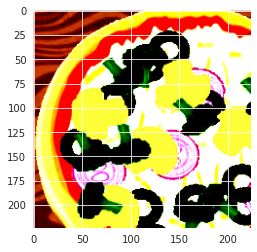

torch.Size([50, 3, 224, 224])


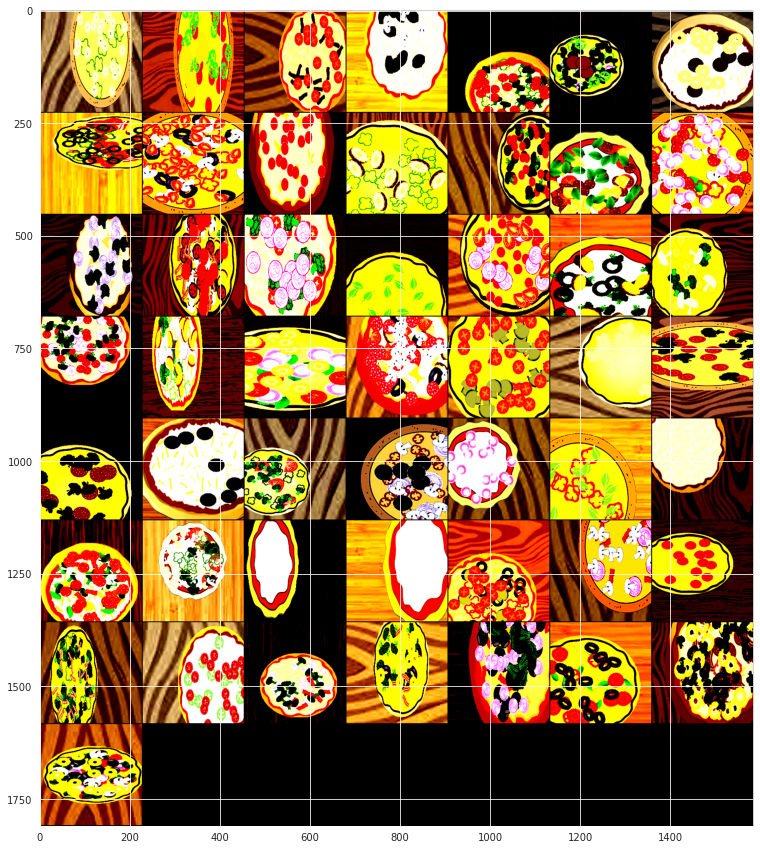

In [ ]:
# Show dataset sample
x,y = test_set_raw[45]

plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

sample,labels = next(iter(train_dataloader))
print(sample.shape)

for images, labels in train_dataloader:
  fig, ax = plt.subplots(figsize=(15,15))
  ax.imshow(torchvision.utils.make_grid(images,7).permute(1,2,0))
  break

### Frequency of each toping in all the Dataset

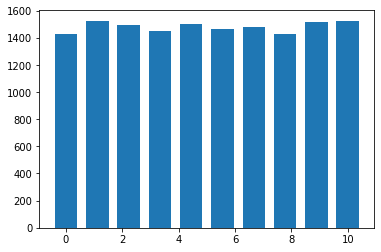

In [34]:
nb_of_toppings = np.zeros(10)

for pizza in y_all:
  nb_of_toppings = nb_of_toppings + pizza

plt.figure()
plt.bar(np.linspace(0,10,10), nb_of_toppings)
plt.show()

We see that each topping is greatly representing in the Dataset with no iver-representing topping

## <font size = "7"> 2 - CNN from scratch </font>





### Network

Simple réseau de neurone convolutionnel

In [36]:
# network class
class SimpleCNN(nn.Module):
# Network requires 32x32 input images  
  def __init__(self, nlabel = 10):
    super(SimpleCNN, self).__init__()
    self.nlabel = nlabel
    
    # define here the convolutions and linear layers
    self.conv1 = nn.Conv2d(3,16,3)
    self.conv2 = nn.Conv2d(16,32,3)
    self.conv3 = nn.Conv2d(32,64,3)
    self.lin1 = nn.Linear(256, 128)
    self.lin2 = nn.Linear(128, self.nlabel)
    
  def forward(self, x):
    
    # 32x32
    
    # define here the forward pass
    x1 = self.conv1(x)
    x1r = F.relu(x1)
    x1p = F.max_pool2d(x1r, 2)
    
    # 16x16
    x2 = self.conv2(x1p)
    x2r = F.relu(x2)
    x2p = F.max_pool2d(x2r, 2)
    
    # 8x8
    x3 = self.conv3(x2p)
    x3r = F.relu(x3)
    x3p = F.max_pool2d(x3r, 2)
    
    # 4x4
    y0 = x3p.view(x3p.size(0), -1)
    
    y1 = self.lin1(y0)
    y1r = F.relu(y1)
    y2 = self.lin2(y1r)

    return y2

### Learning

######<font size = "2"> Choice of the network 

In [38]:
print("Bon nombre de labels : ",nlabel == y_all.shape[1])
print("nlabel : ", nlabel,"\n")

Bon nombre de labels :  True
nlabel :  10 



In [52]:
networkCNN = SimpleCNN(nlabel = nlabel)
# Name of the network
tagCNN = "simpleCNN_V2"

In [53]:
network = networkCNN
tag = tagCNN

In [ ]:
network.eval

###### <font size = "2"> Hyperparameters

In [54]:
max_learning_rate = 0.01
max_epoch = 20

In [55]:
# Define data loaders
trainloader = train_dataloader
valloader = val_dataloader

In [56]:
# Transfer network to GPU/CPU
network.to(device)

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCEWithLogitsLoss() # Sigmoid included
optimizer = torch.optim.Adam(network.parameters(), lr=max_learning_rate)
lambda1 = lambda epoch: 0.95**epoch

#lambda1 = lambda epoch: max(0.99 ** max_epoch, min_learning_rate / max_learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda1) ## Pour modifier le learning rate au fure et à mesure des époques   

Show the learning rate

[0.01, 0.0095, 0.009025, 0.00857375, 0.0081450625, 0.007737809374999998, 0.007350918906249998, 0.006983372960937498, 0.006634204312890623, 0.006302494097246091, 0.005987369392383787, 0.005688000922764597, 0.005403600876626367, 0.005133420832795048, 0.0048767497911552955, 0.00463291230159753, 0.0044012666865176535, 0.004181203352191771, 0.003972143184582182, 0.0037735360253530726, 0.0035848592240854188, 0.003405616262881148, 0.0032353354497370902, 0.003073568677250236, 0.002919890243387724, 0.002773895731218338, 0.0026352009446574203, 0.002503440897424549, 0.0023782688525533216, 0.0022593554099256557, 0.0021463876394293728, 0.0020390682574579037, 0.0019371148445850087, 0.0018402591023557583, 0.0017482461472379703, 0.0016608338398760717, 0.001577792147882268, 0.0014989025404881545, 0.0014239574134637467, 0.0013527595427905593, 0.0012851215656510312, 0.0012208654873684796, 0.0011598222130000556, 0.0011018311023500529, 0.0010467395472325502, 0.0009944025698709225, 0.0009446824413773763, 0.

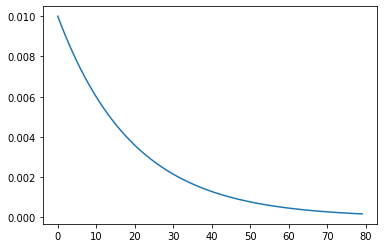

In [57]:
lrs = []
for i in range(80):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(80),lrs)
print(lrs)

###### <font size = "2"> Learning

In [ ]:
learned_model, train_perf, test_perf, train_losses, val_losses = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)
#save the model:
torch.save(learned_model, os.path.join(img_path, 'network_nbepoch=20_{:s}.pth'.format(tag)))
network = learned_model

In [ ]:
plot_loss_results(train_losses, val_losses, train_perf, test_perf)

Un entrainement sur plus d'epoch pourrait nous donner un réseau intéressant, nous préfererons, pour un soucis de rapidité, s'intéresser au stransfer learning.

## <font size = "7"> 3 - Feature extraction

Dans cette partie nous allons étudier l'efficacité de différentes méthodes d'apprentissage en sortie d'un réseau de neurones pré-entrainé. 

La première approche a été de classifier la sortie de ResNext avec des méthodes de classification supervisée vues en cours.

La deuxième consiste à entraîner un MLP avec la sortie d'un CNN déjà entrainé. 

Noter qu'ici nous ne touchons en rien aux poids du réseau initial, seule sa sortie est traitée.

#### <font size = "5">Extraction dataset

In [62]:
class Dataset_Extraction(Dataset):
  def __init__(self, x_idx, y):
    self.x_idx = x_idx
    self.y = y

  def __len__(self):
    return int(len(self.x_idx))

  def __getitem__(self, idx):
    x = self.x_idx[idx]
    y = self.y[idx,:]
    return x,y

### <font size = "6"> ResNext + Classifier



Un Resnet est un réseau qui va interconnecter des neurones jusqu'à plus d'une couche. Il est composé de bloc résiduel les uns à la suite des autres. Cela permet de réduire l'explosion ou la chute du gradient durant l'optimisation. Ce phénomène apparaît lorsqu'il y a beaucoup de couches. Nous avons donc suivi dans un premier temps les indications du sujet et traité la sortie du Resnet. En particulier, c'est un ResNext 50 qui est utilisé, utilisant également à de l'inception et de la profondeur.

Dans cette partie, nous allons tester différentes méthodes de classification en sortie du ResNext. ResNext reste assez simple et léger pour évaluer l'ensemble du data set.


######Utils

In [63]:
#Bliotheque necessaire à la classification 
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [64]:
def True_ratio(y_val,y_val_pred):
  ratio_list=[]
  for i in range(y_val.shape[1]): 
    nb_of_true_overall=0
    nb_of_true=0
    ratio=0
    for j in range(y_val.shape[0]) :
      if y_val[j,i]==1 :
        nb_of_true_overall=nb_of_true_overall+1
        if y_val_pred[j,i]==y_val[j,i] :
          nb_of_true=nb_of_true+1
    if nb_of_true_overall!=0 :
      ratio=nb_of_true/nb_of_true_overall
      ratio_list.append(ratio)
  return ratio_list

#### Extraction à partir du réseau resnext

##### Extraction des features des images d'entrainement **SANS transformation**

In [65]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat1_resnext.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from {}".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
  resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)

  if device.type == 'cuda':
      resnext = resnext.cuda()

  model = resnext

  # Removes the last classification layer: may different for other network
  modules=list(model.children())[:-1]
  model=nn.Sequential(*modules)
  for p in model.parameters():
      p.requires_grad = False

  # If you need to put the last layer back
  #num_ftrs = resnext.fc.in_features
  #resnext.fc = nn.Linear(num_ftrs, 9)

  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform = val_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données 
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)

feat1 = feat
del feat

Loading image features from /content/gdrive/MyDrive/ProjectMI201/syntheticDataset/train/img_all_feat1_resnext.npz


#####Extraction des features des images d'entrainement **AVEC transformation**

In [66]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat2_resnext.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from {}".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
  resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)

  if device.type == 'cuda':
      resnext = resnext.cuda()

  model = resnext

  # Removes the last classification layer: may different for other network
  modules=list(model.children())[:-1]
  model=nn.Sequential(*modules)
  for p in model.parameters():
      p.requires_grad = False

  # If you need to put the last layer back
  #num_ftrs = resnext.fc.in_features
  #resnext.fc = nn.Linear(num_ftrs, 9)

  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform = train_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données 
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)

feat2 = feat
del feat

Loading image features from /content/gdrive/MyDrive/ProjectMI201/syntheticDataset/train/img_all_feat2_resnext.npz


##### Extraction des features des images de test sans transformation

In [67]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/test/img_all_featTest_resnext.npz')


# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from {}".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights
  resnext = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)

  if device.type == 'cuda':
      resnext = resnext.cuda()

  model = resnext

  # Removes the last classification layer: may different for other network
  modules=list(model.children())[:-1]
  model=nn.Sequential(*modules)
  for p in model.parameters():
      p.requires_grad = False

  # If you need to put the last layer back
  #num_ftrs = resnext.fc.in_features
  #resnext.fc = nn.Linear(num_ftrs, 9)

  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_test, y_test, img_path=test_data_path, img_data=img_test, transform = val_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données 
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)

feat_test = feat
del feat

Loading image features from /content/gdrive/MyDrive/ProjectMI201/syntheticDataset/test/img_all_featTest_resnext.npz


##### Création des données d'entrainement et de validation

Multiplication par 2 du dataset de base grace aux transformations.

- feat1 contient chaque image non transformée
- feat2 contient chaque image transformée

On concatène ces listes de données et on mélange la liste résultante dans la fonction train_test_split(...) par la suite.


In [68]:
feat_double = np.concatenate((feat1, feat2), axis = 0)
y_all_double = np.concatenate((y_all, y_all), axis = 0)

In [69]:
X_train, X_val, y_train, y_val = train_test_split(feat_double, y_all_double, test_size=0.2, random_state=123)

#### SVM

Ici, nous testons un SVM lineair.

Dans cette partie et dans la suite, il est important de préciser à SKLearn que les outputs sont multiples avec la fonction *MultiOutputClassifier()*.


In [ ]:
multiclass_SVM = MultiOutputClassifier(LinearSVC(random_state=42, C=2))

In [ ]:
#Training
multiclass_SVM= multiclass_SVM.fit(X_train, y_train)

In [ ]:
#Predict 
y_val_pred = multiclass_SVM.predict(X_val)

Ici se pose la question de la représentions de l'efficacité des classifieurs.

Nous avons d'abord pensé à des matrices de confusion pour chacune des classes.

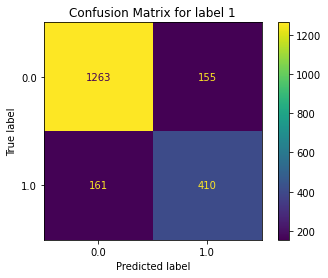

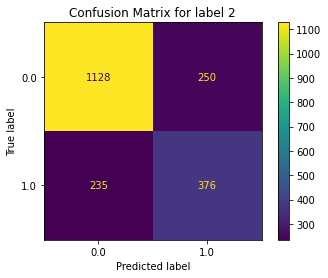

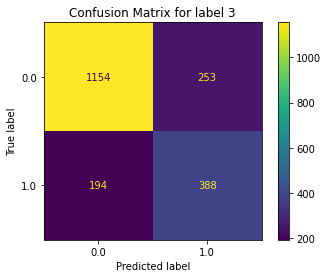

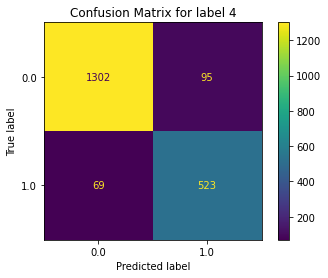

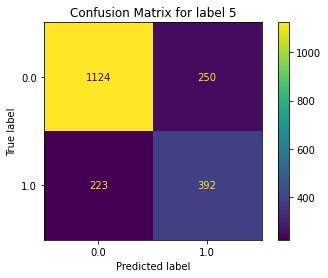

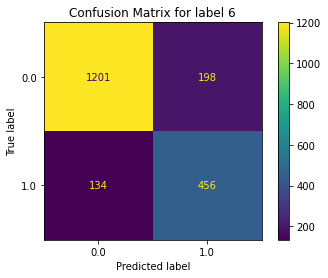

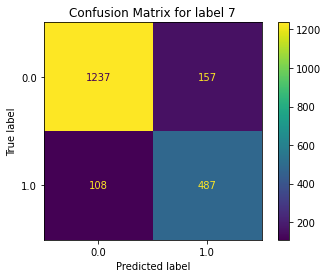

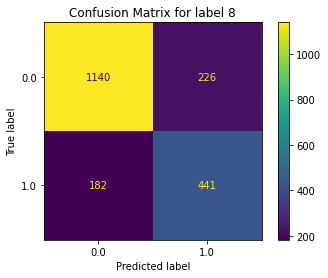

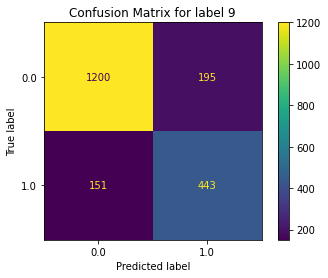

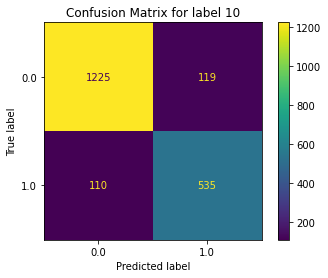

In [ ]:
# Confusion Matrix multiclass
matrices = multilabel_confusion_matrix(y_val, y_val_pred)
nlabels = 10
for k in range(nlabels):
  cmd = ConfusionMatrixDisplay(matrices[k], display_labels=np.unique(y_test)).plot()
  plt.title('Confusion Matrix for label {}'.format(k+1))
  plt.show()

Il est assez compliqué d'interpréter les résultats.

En effet, dans la majorité des cas, pour un topping donné, il ne sera pas là. C'est la raison pour laquelle le cadrant en haut à gauche est rempli. De plus, il est assez difficile de voir autant de matrice d'un coup. Les matrices ne sont pas forcément adaptées à l'analyse de méthodes pour notre problème.

Nous nous sommes dirigés naturellement vers un pourcentage réussite par classe.


[84.11261941 75.61588738 77.52639517 91.75465058 76.21920563 83.30819507
 86.67672197 79.48717949 82.60432378 88.48667672]


<BarContainer object of 10 artists>

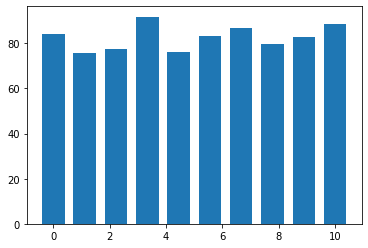

In [ ]:
# Bar charts for average predictios
perf_label_val = np.zeros(nlabels)
for k in range(len(y_val_pred)):
  perf_label_val = perf_label_val + (y_val[k] == y_val_pred[k])

res = perf_label_val/y_val_pred.shape[0]*100

print(res)

plt.figure()
plt.bar(np.linspace(0,10,10), perf_label_val/y_val_pred.shape[0]*100)

Ici, les scores peuvent paraitre bons. Mais comme souligne déjà plus, ce que nous voulons principalement, c'est savoir : pour un topping donné, quand est-ce que le modèle a bien prédit.

Nous avons donc mis en place cette métrique : True_ratio. Elle peut paraitre trop forte de prime abord, mais elle a le mérite de briller lorsque les résultats sont convaincants.

[0.7180385288966725, 0.6153846153846154, 0.6666666666666666, 0.8834459459459459, 0.6373983739837399, 0.7728813559322034, 0.8184873949579832, 0.7078651685393258, 0.7457912457912458, 0.8294573643410853]
Overall :  0.7395416660439483


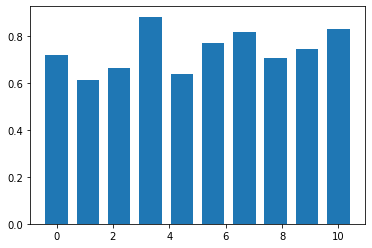

In [ ]:
# Bar charts for when true predictions
Ratios_SVM = True_ratio(y_val,y_val_pred)
print(Ratios_SVM)
plt.figure()
plt.bar(np.linspace(0,10,10),Ratios_SVM)
print('Overall : ', np.array(Ratios_SVM).mean() ) # moyenne des scores

Nous pouvons donc voir ici que le SVM ne produit pas des scores très élevés.

Nous avions également testé un SVM non linéaire, mais le temps d'entrainement et de prédiction était bien trop élevé pour un score trop bas.

#### KNN
Nous essayons egalment les K voisins :

In [ ]:
multiclass_KNN = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                             metric='minkowski', metric_params=None, n_jobs=None))

In [ ]:
multiclass_KNN = multiclass_KNN.fit(X_train, y_train)

Apres quelques tests, 7 semble être le meilleurs compromis perfomance resultats

In [ ]:
#Predict (no training for Knn)
y_val_pred = multiclass_KNN.predict(X_val)

[0.5201401050788091, 0.33060556464811786, 0.38316151202749144, 0.5337837837837838, 0.39186991869918697, 0.47966101694915253, 0.5176470588235295, 0.45425361155698235, 0.5050505050505051, 0.46511627906976744]
Overall :  0.4581289355687326


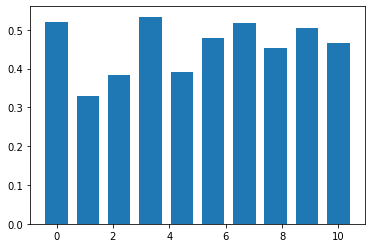

In [ ]:
# Bar charts for when true predictions
Ratios_knn = True_ratio(y_val,y_val_pred)
print(Ratios_knn)
plt.figure()
plt.bar(np.linspace(0,10,10),Ratios_knn)
print('Overall : ', np.array(Ratios_knn).mean() ) # moyenne des scores

On remarque que l'algorithme des k plus proches voisins ne fournit pas de résultats satisfaisants.

#### Random Forest



In [ ]:
multiclass_RandomFor = MultiOutputClassifier(RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None,
                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                               max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
                               oob_score=False, n_jobs=None, random_state=None, verbose=1, warm_start=False, class_weight=None, 
                               ccp_alpha=0.0, max_samples=None))

In [ ]:
#Training
multiclass_RandomFor = multiclass_RandomFor.fit(X_train, y_train)

In [ ]:
#Predict 
y_val_pred = multiclass_RandomFor.predict(X_val)

In [ ]:
# Bar charts for when true predictions
Ratios_for = True_ratio(y_val,y_val_pred)
print(Ratios_for)
plt.figure()
plt.bar(np.linspace(0,10,10),Ratios_for)
print('Overall : ', np.array(Ratios_for).mean() ) # moyenne des scores

Comme on peut le voir Random forrest ne fournit pas des resultats satisfaisant.

#### Perceptron

In [ ]:
multiclass_Perceptron = MultiOutputClassifier(Perceptron(penalty = 'elasticnet',verbose=1))


Apres quelques tests, elasticnet avait l'air de fonctionner le mieux .

In [ ]:
multiclass_Perceptron = multiclass_Perceptron.fit(X_train, y_train)

In [ ]:
#Predict 
y_val_pred = multiclass_Perceptron.predict(X_val)

[0.3169877408056042, 0.6399345335515548, 0.5240549828178694, 0.8986486486486487, 0.7040650406504065, 0.8016949152542373, 0.6840336134453782, 0.8940609951845907, 0.835016835016835, 0.8666666666666667]
Overall :  0.716516397204179


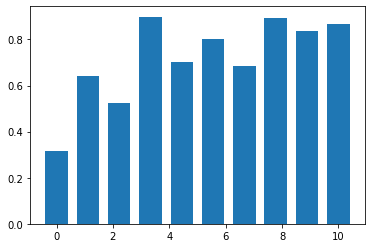

In [ ]:
# Bar charts for when true predictions
Ratios_Per = True_ratio(y_val,y_val_pred)
print(Ratios_Per)
plt.figure()
plt.bar(np.linspace(0,10,10),Ratios_Per)
print('Overall : ', np.array(Ratios_Per).mean() ) # moyenne des scores

Le perceptron fournis des résultats convaincant par rapport à d'autre classifieur. C'est un équivalent à un MLP à une couche. Ce qui nous a poussé à greffer un MLP un peu plus développé à la sortie du réseau pré entrainé sur des images. 

### <font size = "6"> Pre-trained CNN + MLP


#### <font size = "5"> ResNext + MLP

Création des dataloaders à partir des données sorties du Resnext : 

In [ ]:
feat_train, feat_val, yfeat_train, yfeat_val = train_test_split(feat_double, y_all_double, test_size=0.1, random_state=123, shuffle = True)

feat_train_set_row = Dataset_Extraction(feat_train, yfeat_train)
feat_trainloader = torch.utils.data.DataLoader(feat_train_set_row, batch_size=25, shuffle=True, **kwargs)

feat_val_set_row = Dataset_Extraction(feat_val, yfeat_val)
feat_valloader = torch.utils.data.DataLoader(feat_val_set_row, batch_size=25, shuffle=True, **kwargs)

feat_test_set_row = Dataset_Extraction(feat_test, y_test)
feat_testloader = torch.utils.data.DataLoader(feat_test_set_row, batch_size=25, shuffle=False, **kwargs)

Entrainement :

In [ ]:
class LastLayersNN(nn.Module):

  def __init__(self, dim_input = 2048,  nlabels = 10):
    super(LastLayersNN, self).__init__()
    self.nlabels = nlabels
    
    self.lin = nn.Linear(dim_input, 1000)
    self.lin1 = nn.Linear(1000, nlabels)

    self.dropout = nn.Dropout(p=0.3)  

  def forward(self, x):

    x = self.lin(x)
    x = nn.functional.relu(x)
    x = self.dropout(x)

    x = self.lin1(x)

    return x

In [ ]:
networkRES = LastLayersNN(2048, nlabel)

# Name of the network
tagRES = "pretrainedNN_with_resnxet"

In [73]:
trainloader = feat_trainloader
valloader = feat_valloader

In [ ]:
networkRES.to(device)

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(networkRES.parameters(), lr=1)
lambda1 = lambda epoch: 0.95**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda1)
# Learning 

max_epoch = 15
learned_model, train_perf, val_perf, train_losses, val_losses = train_model_multilabel(networkRES, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)

network = learned_model

Affichage des fonctions Loss (Train et Val) et résultats de Validation sur la dernière epoch :

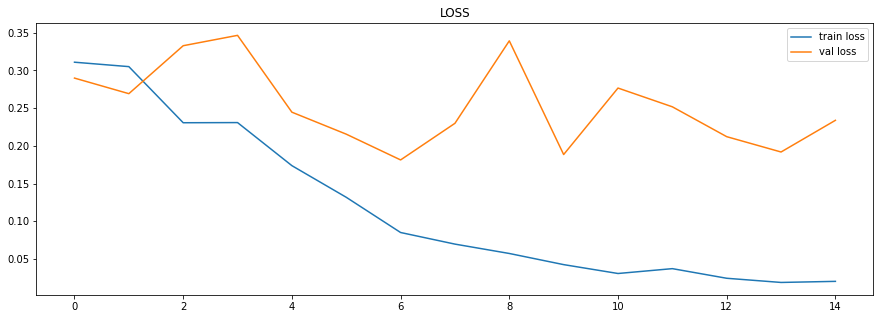

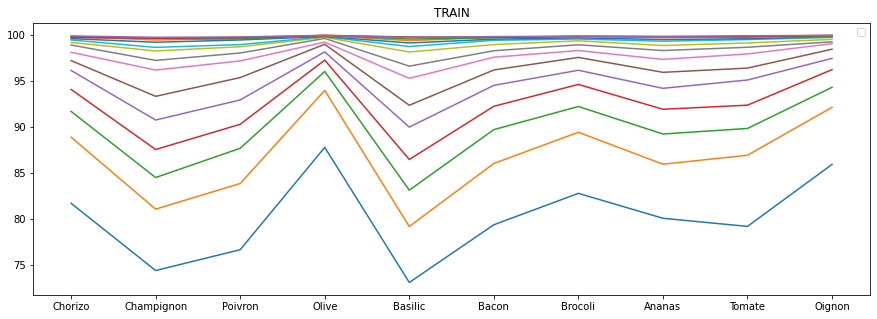

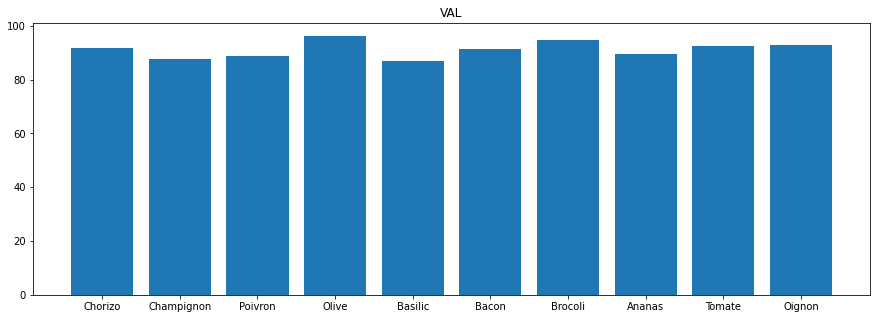

In [75]:
plot_loss_results(train_losses, val_losses, train_perf, val_perf)

Phase de test

In [ ]:
Test(network, feat_testloader)

####<font size = "5"> VGG + MLP

##### <font size = "4">Model Loading

In [ ]:
model = torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.eval

In [ ]:
# Removes last layers (Classifier and avgpool)
class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()

  def forward(self, x):
    return x

#removes avgpool :
model.avgpool = Identity()

#change classifier :
#model.classifier = nn.Sequential(nn.Linear(512, 100)) #,nn.Dropout(p=0.4),nn.Linear(100,10))
model.classifier = Identity()

Last Layer

Il s'agit de la dernière couche que l'on va entrainer à la suite du réseau chargé

In [ ]:
class LastLayersVGG(nn.Module):

  def __init__(self, dim_input = 512,  nlabels = 10):
    super(LastLayersVGG, self).__init__()
    self.nlabels = nlabels
    
    # define here the convolutions and linear layers
    self.lin = nn.Linear(dim_input, 100)
    self.lin1 = nn.Linear(100, nlabels)
    self.dropout = nn.Dropout(p=0.3)  

  def forward(self, x):

    x = self.lin(x)
    x = nn.functional.relu(x)
    x = self.dropout(x)
    x = self.lin1(x)

    return x

##### <font size = "4">Feat Data Load

In [ ]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat1_vgg.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from {}".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  if device.type == 'cuda':
      model = model.cuda()


  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform = val_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données 
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)

feat1 = feat
del feat

Loading image features from /content/gdrive/MyDrive/Ensta/MI201/Project/data_tao/syntheticDataset/train/img_all_feat1_vgg.npz


In [ ]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat2_vgg.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from {}".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  if device.type == 'cuda':
      model = model.cuda()


  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform = train_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données 
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)

feat2 = feat
del feat

Loading image features from /content/gdrive/MyDrive/Ensta/MI201/Project/data_tao/syntheticDataset/train/img_all_feat2_vgg.npz


In [ ]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/test/img_all_featTEST_vgg.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from {}".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  if device.type == 'cuda':
      model = model.cuda()


  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_test, y_test, img_path=test_data_path, img_data=img_test, transform = val_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données 
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)

feat_test = feat
del feat

Loading image features from /content/gdrive/MyDrive/Ensta/MI201/Project/data_tao/syntheticDataset/test/img_all_featTEST_vgg.npz


In [ ]:
feat_double = np.concatenate((feat1, feat2), axis = 0)
y_all_double = np.concatenate((y_all, y_all), axis = 0)

In [ ]:
# Use the same random seed to generate the same split
feat_train, feat_val, yfeat_train, yfeat_val = train_test_split(feat_double, y_all_double, test_size=0.2, random_state=123, shuffle = True)

feat_train_set_row = Dataset_Extraction(feat_train, yfeat_train)
feat_trainloader = torch.utils.data.DataLoader(feat_train_set_row, batch_size=15, shuffle=True, **kwargs)

feat_val_set_row = Dataset_Extraction(feat_val, yfeat_val)
feat_valloader = torch.utils.data.DataLoader(feat_val_set_row, batch_size=15, shuffle=True, **kwargs)

feat_test_set_row = Dataset_Extraction(feat_test, y_test)
feat_testloader = torch.utils.data.DataLoader(feat_test_set_row, batch_size=15, shuffle=False, **kwargs)

In [ ]:
print("len feat train: ",len(feat_train))
print(feat_train.shape)
print(len(feat_trainloader))

len feat train:  7953
(7953, 512)
531


##### <font size = "4">Learning VGG + MLP 

######<font size = "2"> Choice of the network 

In [ ]:
print("Bon nombre de labels : ",nlabel == y_all.shape[1])
print("nlabel : ", nlabel,"\n")

Bon nombre de labels :  True
nlabel :  10 



VGG

In [ ]:
networkVGG = LastLayersVGG(512, nlabel)
tagVGG = "pretrained_vgg"

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(networkVGG):,} trainable parameters')
print("\n",networkVGG)

The model has 52,310 trainable parameters

 LastLayersVGG(
  (lin): Linear(in_features=512, out_features=100, bias=True)
  (lin1): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


**CHOICE**

In [ ]:
network = networkVGG
tag = tagVGG

In [ ]:
network.eval

###### <font size = "2"> Hyperparameters

In [ ]:
max_learning_rate = 0.01
max_epoch = 20

In [ ]:
# Define data loaders
trainloader = feat_trainloader
valloader = feat_valloader

In [ ]:
# Transfer network to GPU/CPU
network.to(device)

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCEWithLogitsLoss() # Sigmoid included
optimizer = torch.optim.Adam(network.parameters(), lr=max_learning_rate)
lambda1 = lambda epoch: 0.95**epoch

#lambda1 = lambda epoch: max(0.99 ** max_epoch, min_learning_rate / max_learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda1) ## Pour modifier le learning rate au fure et à mesure des époques   

Show the learning rate

[0.01, 0.0095, 0.009025, 0.00857375, 0.0081450625, 0.007737809374999998, 0.007350918906249998, 0.006983372960937498, 0.006634204312890623, 0.006302494097246091, 0.005987369392383787, 0.005688000922764597, 0.005403600876626367, 0.005133420832795048, 0.0048767497911552955, 0.00463291230159753, 0.0044012666865176535, 0.004181203352191771, 0.003972143184582182, 0.0037735360253530726, 0.0035848592240854188, 0.003405616262881148, 0.0032353354497370902, 0.003073568677250236, 0.002919890243387724, 0.002773895731218338, 0.0026352009446574203, 0.002503440897424549, 0.0023782688525533216, 0.0022593554099256557, 0.0021463876394293728, 0.0020390682574579037, 0.0019371148445850087, 0.0018402591023557583, 0.0017482461472379703, 0.0016608338398760717, 0.001577792147882268, 0.0014989025404881545, 0.0014239574134637467, 0.0013527595427905593, 0.0012851215656510312, 0.0012208654873684796, 0.0011598222130000556, 0.0011018311023500529, 0.0010467395472325502, 0.0009944025698709225, 0.0009446824413773763, 0.

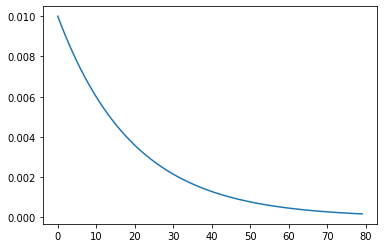

In [ ]:
lrs = []
for i in range(80):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ", round(0.65 ** i,3)," , Learning Rate = ",round(optimizer.param_groups[0]["lr"],3))
    scheduler.step()

plt.plot(range(80),lrs)
print(lrs)

###### <font size = "2"> Learning

In [ ]:
learned_model, train_perf, val_perf, train_losses, val_losses = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)
#save the model:
torch.save(learned_model, os.path.join(img_path, 'network_nbepoch=20_{:s}.pth'.format(tag)))
network = learned_model

-------------- Epoch 1 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 632.18it/s]


learning rate :  5.9205292203339975e-05

Train perf mean:  0.766754683767132 



100%|██████████| 133/133 [00:00<00:00, 2491.94it/s]



val loss: 0.55621737241745

Test perf mean:  0.7465560583207642 




-------------- Epoch 2 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 903.81it/s]


learning rate :  5.624502759317297e-05

Train perf mean:  0.7671318999119829 



100%|██████████| 133/133 [00:00<00:00, 2430.88it/s]



val loss: 0.4896557629108429

Test perf mean:  0.7469079939668175 




-------------- Epoch 3 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 906.11it/s]


learning rate :  5.343277621351433e-05

Train perf mean:  0.76792405381617 



100%|██████████| 133/133 [00:00<00:00, 2479.20it/s]



val loss: 0.5400416851043701

Test perf mean:  0.7461538461538462 




-------------- Epoch 4 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 895.70it/s]


learning rate :  5.07611374028386e-05

Train perf mean:  0.7690179806362378 



100%|██████████| 133/133 [00:00<00:00, 2179.23it/s]



val loss: 0.4143375754356384

Test perf mean:  0.7457516339869281 




-------------- Epoch 5 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 913.92it/s]


learning rate :  4.822308053269668e-05

Train perf mean:  0.7692568841946436 



100%|██████████| 133/133 [00:00<00:00, 2041.99it/s]



val loss: 0.5160722136497498

Test perf mean:  0.746606334841629 




-------------- Epoch 6 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 892.70it/s]


learning rate :  4.581192650606184e-05

Train perf mean:  0.7699987426128506 



100%|██████████| 133/133 [00:00<00:00, 2585.09it/s]



val loss: 0.41311419010162354

Test perf mean:  0.7461538461538462 




-------------- Epoch 7 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 876.92it/s]


learning rate :  4.3521330180758743e-05

Train perf mean:  0.7696718219539795 



100%|██████████| 133/133 [00:00<00:00, 2344.02it/s]



val loss: 0.5444897413253784

Test perf mean:  0.7453996983408748 




-------------- Epoch 8 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 906.13it/s]


learning rate :  4.134526367172081e-05

Train perf mean:  0.7721363007670062 



100%|██████████| 133/133 [00:00<00:00, 2196.65it/s]



val loss: 0.4197051525115967

Test perf mean:  0.7452488687782806 




-------------- Epoch 9 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 903.98it/s]


learning rate :  3.9278000488134766e-05

Train perf mean:  0.7722243178674714 



100%|██████████| 133/133 [00:00<00:00, 2465.68it/s]



val loss: 0.5062659978866577

Test perf mean:  0.7456008044243339 




-------------- Epoch 10 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 898.68it/s]


learning rate :  3.7314100463728024e-05

Train perf mean:  0.7727398465987678 



100%|██████████| 133/133 [00:00<00:00, 2571.41it/s]



val loss: 0.5312550663948059

Test perf mean:  0.7468577174459528 




-------------- Epoch 11 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 899.81it/s]


learning rate :  3.544839544054162e-05

Train perf mean:  0.772488369168867 



100%|██████████| 133/133 [00:00<00:00, 2604.74it/s]



val loss: 0.5442517995834351

Test perf mean:  0.7458019105077929 




-------------- Epoch 12 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 888.65it/s]


learning rate :  3.367597566851454e-05

Train perf mean:  0.7713567207343142 



100%|██████████| 133/133 [00:00<00:00, 2230.01it/s]



val loss: 0.46877360343933105

Test perf mean:  0.7454499748617396 




-------------- Epoch 13 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 877.77it/s]


learning rate :  3.199217688508881e-05

Train perf mean:  0.772450647554382 



100%|██████████| 133/133 [00:00<00:00, 2337.93it/s]



val loss: 0.5745304226875305

Test perf mean:  0.7460532931121167 




-------------- Epoch 14 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 906.09it/s]


learning rate :  3.0392568040834368e-05

Train perf mean:  0.7736451653464101 



100%|██████████| 133/133 [00:00<00:00, 2549.01it/s]



val loss: 0.523612916469574

Test perf mean:  0.7456008044243339 




-------------- Epoch 15 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 905.30it/s]


learning rate :  2.8872939638792648e-05

Train perf mean:  0.7745756318370426 



100%|██████████| 133/133 [00:00<00:00, 2427.22it/s]



val loss: 0.4937731921672821

Test perf mean:  0.7462543991955757 




-------------- Epoch 16 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 906.36it/s]


learning rate :  2.7429292656853014e-05

Train perf mean:  0.7733308185590343 



100%|██████████| 133/133 [00:00<00:00, 2093.70it/s]



val loss: 0.5352290868759155

Test perf mean:  0.7457516339869281 




-------------- Epoch 17 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 920.72it/s]


learning rate :  2.6057828024010365e-05

Train perf mean:  0.7756569847856154 



100%|██████████| 133/133 [00:00<00:00, 2168.45it/s]



val loss: 0.5454326868057251

Test perf mean:  0.7465057817998995 




-------------- Epoch 18 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 899.26it/s]


learning rate :  2.4754936622809846e-05

Train perf mean:  0.773959512133786 



100%|██████████| 133/133 [00:00<00:00, 2215.21it/s]



val loss: 0.5026265978813171

Test perf mean:  0.7460532931121167 




-------------- Epoch 19 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 883.93it/s]


learning rate :  2.351718979166935e-05

Train perf mean:  0.7750785866968439 



100%|██████████| 133/133 [00:00<00:00, 2518.94it/s]



val loss: 0.5145764350891113

Test perf mean:  0.7459024635495224 




-------------- Epoch 20 / 20  ------------



100%|██████████| 531/531 [00:00<00:00, 919.24it/s]


learning rate :  2.234133030208588e-05

Train perf mean:  0.773921790519301 



100%|██████████| 133/133 [00:00<00:00, 2485.26it/s]



val loss: 0.4960635304450989

Test perf mean:  0.7459527400703871 






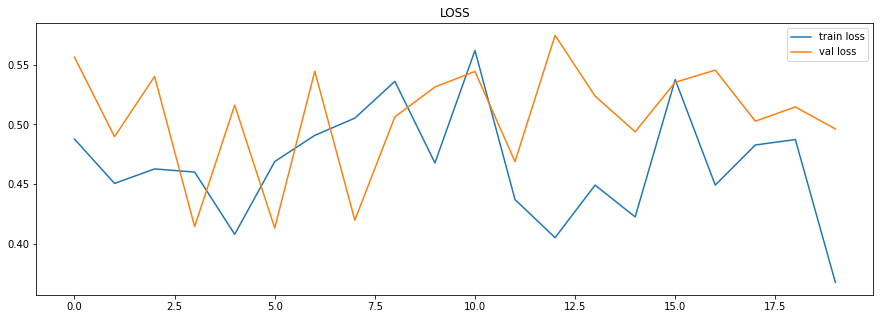

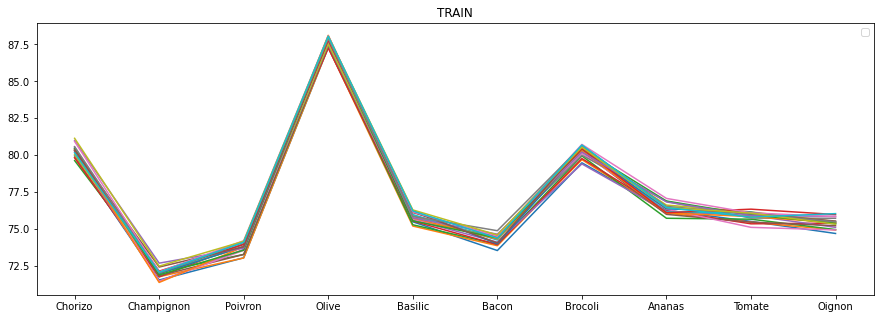

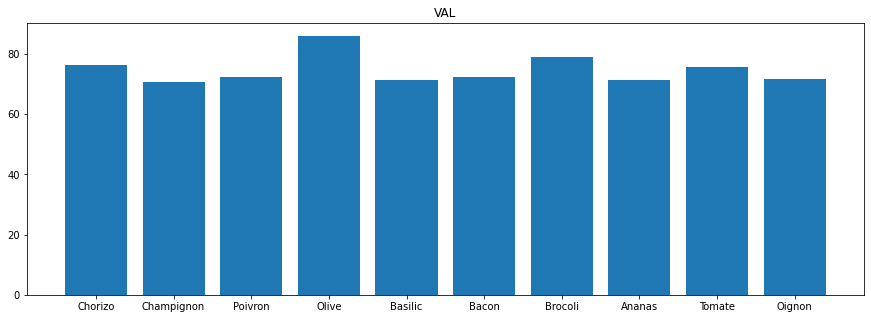

In [ ]:
plot_loss_results(train_losses, val_losses, train_perf, val_perf)

Le résultat n'est pas du tout convainquant

#### <font size = "5">AlexNet + MLP

##### <font size = "2">Model Loading

In [ ]:
networkALEX = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
tagALEX = "AlexNet"

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
networkALEX.eval()

In [ ]:
# Removes 
class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()

  def forward(self, x):
    return x

#removes avgpool :
networkALEX.avgpool = Identity()

#change classifier :
networkALEX.classifier = nn.Sequential(nn.Linear(in_features=9216, out_features=4096, bias=True)) #,nn.Dropout(p=0.4),nn.Linear(100,10))
#networkALEX.classifier = Identity()

In [ ]:
networkALEX.eval

In [ ]:
class LastLayersAlex(nn.Module):

  def __init__(self, dim_input = 4096,  nlabels = 10):
    super(LastLayersAlex, self).__init__()
    self.nlabels = nlabels
    
    # define here the convolutions and linear layers
    self.lin1 = nn.Linear(dim_input, 1000)
    self.dropout = nn.Dropout(p=0.3)  
    self.lin2 = nn.Linear(1000, 10)

  def forward(self, x):

    x = self.lin1(x)
    x = nn.functional.relu(x)
    x = self.dropout(x)
    x = self.lin2(x)

    return x

##### <font size = "2">Feat Data Load

In [ ]:
model = networkALEX

In [ ]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat1_ALEX.npz')
# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from {}".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  if device.type == 'cuda':
      model = model.cuda()


  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform = val_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données 
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)

feat1 = feat
del feat

Loading image features from /content/gdrive/MyDrive/Ensta/MI201/Project/data_tao/syntheticDataset/train/img_all_feat1_ALEX.npz


In [ ]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/train/img_all_feat2_ALEX.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from {}".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  if device.type == 'cuda':
      model = model.cuda()


  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_all, y_all, img_path=train_data_path, img_data=img_all, transform = train_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données 
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)

feat2 = feat
del feat

Loading image features from /content/gdrive/MyDrive/Ensta/MI201/Project/data_tao/syntheticDataset/train/img_all_feat2_ALEX.npz


In [ ]:
feat_data_path=os.path.join(DATA_DIR, 'syntheticDataset/test/img_all_featTEST_ALEX.npz')

# Checks if features already exist
if os.path.exists(feat_data_path):
  print("Loading image features from {}".format(feat_data_path))
  feat = np.load(feat_data_path)
  feat = feat['img_feat']

# If not, compute them
else:

  print("Computing image features")

  if device.type == 'cuda':
      model = model.cuda()


  # Uses a dataloader with no data augmentation
  all_set_raw = myDataset(x_test, y_test, img_path=test_data_path, img_data=img_test, transform = val_transform)
  all_dataloader_feat = DataLoader(all_set_raw, batch_size=200, shuffle=False, **kwargs)

  feat = []
  for i, data in enumerate(tqdm(all_dataloader_feat)):   ## on itere sur les données 
      img, targets = data
      #print(targets)
      if device.type == 'cuda':
          img, targets = img.cuda(), targets.cuda()
      with torch.no_grad():
          outputs = model(img)
      if device.type == 'cuda':
          feat.append(outputs.cpu().numpy().squeeze())
      else:
          feat.append(outputs.numpy().squeeze())

  feat = np.array(np.concatenate(feat))

  print("Storing image features in {}".format(feat_data_path))
  np.savez_compressed(feat_data_path, img_feat=feat)

feat_test = feat
del feat

Loading image features from /content/gdrive/MyDrive/Ensta/MI201/Project/data_tao/syntheticDataset/test/img_all_featTEST_ALEX.npz


In [ ]:
feat_double_ALEX = np.concatenate((feat1, feat2), axis = 0)
y_all_double_ALEX = np.concatenate((y_all, y_all), axis = 0)

In [ ]:
feat_double_ALEX.shape

(9942, 4096)

In [ ]:
# Use the same random seed to generate the same split
feat_train, feat_val, yfeat_train, yfeat_val = train_test_split(feat_double_ALEX, y_all_double_ALEX, test_size=0.2, random_state=123, shuffle = True)

feat_train_set_row = Dataset_Extraction(feat_train, yfeat_train)
feat_trainloader_ALEX = torch.utils.data.DataLoader(feat_train_set_row, batch_size=15, shuffle=True, **kwargs)

feat_val_set_row = Dataset_Extraction(feat_val, yfeat_val)
feat_valloader_ALEX = torch.utils.data.DataLoader(feat_val_set_row, batch_size=15, shuffle=True, **kwargs)

feat_test_set_row = Dataset_Extraction(feat_test, y_test)
feat_testloader_ALEX = torch.utils.data.DataLoader(feat_test_set_row, batch_size=15, shuffle=False, **kwargs)

##### <font size = "4">Learning AlexNet + MLP

######<font size = "2"> Choice of the network 

In [ ]:
print("Bon nombre de labels : ",nlabel == y_all.shape[1])
print("nlabel : ", nlabel,"\n")

Bon nombre de labels :  True
nlabel :  10 



AlexNet

In [ ]:
networkALEX=LastLayersAlex()
tagALEX = "AlexNet"

**CHOICE**

In [ ]:
network = networkALEX
tag = tagALEX

In [ ]:
network.eval

###### <font size = "2"> Hyperparameters

In [ ]:
max_learning_rate = 0.01
max_epoch = 15

In [ ]:
# Define data loaders
trainloader = feat_trainloader_ALEX
valloader = feat_valloader_ALEX

In [ ]:
# Transfer network to GPU/CPU
network.to(device)

# Define learning components (to be used in the learning function)
criterion = torch.nn.BCEWithLogitsLoss() # Sigmoid included
optimizer = torch.optim.Adam(network.parameters(), lr=max_learning_rate)
lambda1 = lambda epoch: 0.90**epoch

#lambda1 = lambda epoch: max(0.99 ** max_epoch, min_learning_rate / max_learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda1) ## Pour modifier le learning rate au fure et à mesure des époques   

Show the learning rate

[0.01, 0.009000000000000001, 0.008100000000000001, 0.007290000000000001, 0.006561, 0.005904900000000001, 0.00531441, 0.004782969000000001, 0.004304672100000001, 0.003874204890000001, 0.003486784401000001, 0.0031381059609000006, 0.0028242953648100013, 0.002541865828329001, 0.002287679245496101]


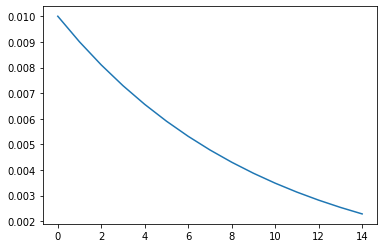

In [ ]:
lrs = []
for i in range(15):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ", round(0.65 ** i,3)," , Learning Rate = ",round(optimizer.param_groups[0]["lr"],3))
    scheduler.step()

plt.plot(range(15),lrs)
print(lrs)

###### <font size = "2"> Learning

In [ ]:
learned_model, train_perf, val_perf, train_losses, val_losses = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)
#save the model:
torch.save(learned_model, os.path.join(img_path, 'network_nbepoch=20_{:s}.pth'.format(tag)))
network = learned_model

-------------- Epoch 1 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.64it/s]


learning rate :  0.002058911320946491

Train perf mean:  0.7539041870992078 



100%|██████████| 133/133 [00:01<00:00, 116.94it/s]



val loss: 0.45386597514152527

Test perf mean:  0.7872800402212168 




-------------- Epoch 2 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.47it/s]


learning rate :  0.0018530201888518416

Train perf mean:  0.7908084999371306 



100%|██████████| 133/133 [00:01<00:00, 117.85it/s]



val loss: 0.45463159680366516

Test perf mean:  0.7972850678733032 




-------------- Epoch 3 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.02it/s]


learning rate :  0.0016677181699666576

Train perf mean:  0.8133911731422104 



100%|██████████| 133/133 [00:01<00:00, 120.33it/s]



val loss: 0.31003275513648987

Test perf mean:  0.8089994972347914 




-------------- Epoch 4 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.10it/s]


learning rate :  0.0015009463529699917

Train perf mean:  0.8337105494781843 



100%|██████████| 133/133 [00:01<00:00, 121.64it/s]



val loss: 0.36157822608947754

Test perf mean:  0.8182503770739065 




-------------- Epoch 5 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.49it/s]


learning rate :  0.0013508517176729928

Train perf mean:  0.8490883943166102 



100%|██████████| 133/133 [00:01<00:00, 120.75it/s]



val loss: 0.4670877456665039

Test perf mean:  0.8212669683257918 




-------------- Epoch 6 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.60it/s]


learning rate :  0.0012157665459056935

Train perf mean:  0.862592732302276 



100%|██████████| 133/133 [00:01<00:00, 123.51it/s]



val loss: 0.46840164065361023

Test perf mean:  0.8285067873303167 




-------------- Epoch 7 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.53it/s]


learning rate :  0.0010941898913151243

Train perf mean:  0.8741481202062115 



100%|██████████| 133/133 [00:01<00:00, 119.40it/s]



val loss: 0.3361426293849945

Test perf mean:  0.828657616892911 




-------------- Epoch 8 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.28it/s]


learning rate :  0.0009847709021836117

Train perf mean:  0.8855400477807118 



100%|██████████| 133/133 [00:01<00:00, 122.13it/s]



val loss: 0.45701485872268677

Test perf mean:  0.8302161890397185 




-------------- Epoch 9 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.63it/s]


learning rate :  0.0008862938119652507

Train perf mean:  0.8949578775304916 



100%|██████████| 133/133 [00:01<00:00, 121.40it/s]



val loss: 0.4117419421672821

Test perf mean:  0.8329311211664152 




-------------- Epoch 10 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.97it/s]


learning rate :  0.0007976644307687256

Train perf mean:  0.9020118194392053 



100%|██████████| 133/133 [00:01<00:00, 118.65it/s]



val loss: 0.4043737053871155

Test perf mean:  0.8339869281045752 




-------------- Epoch 11 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.60it/s]


learning rate :  0.000717897987691853

Train perf mean:  0.9104237394693826 



100%|██████████| 133/133 [00:01<00:00, 118.73it/s]



val loss: 0.5417312979698181

Test perf mean:  0.8368526897938663 




-------------- Epoch 12 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.31it/s]


learning rate :  0.0006461081889226677

Train perf mean:  0.9159813906701875 



100%|██████████| 133/133 [00:01<00:00, 119.40it/s]



val loss: 0.3234495222568512

Test perf mean:  0.8403720462543992 




-------------- Epoch 13 / 15  ------------



100%|██████████| 531/531 [00:16<00:00, 31.47it/s]


learning rate :  0.000581497370030401

Train perf mean:  0.9211115302401609 



100%|██████████| 133/133 [00:01<00:00, 119.87it/s]



val loss: 0.4310669004917145

Test perf mean:  0.8386123680241327 




-------------- Epoch 14 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.67it/s]


learning rate :  0.000523347633027361

Train perf mean:  0.9263548346535899 



100%|██████████| 133/133 [00:01<00:00, 120.75it/s]



val loss: 0.404757559299469

Test perf mean:  0.8399698340874812 




-------------- Epoch 15 / 15  ------------



100%|██████████| 531/531 [00:15<00:00, 34.50it/s]


learning rate :  0.0004710128697246249

Train perf mean:  0.9308311329058216 



100%|██████████| 133/133 [00:01<00:00, 118.65it/s]



val loss: 0.28655779361724854

Test perf mean:  0.8429864253393665 






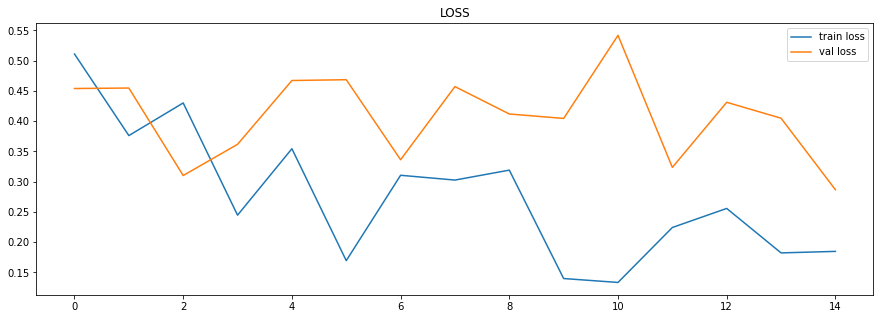

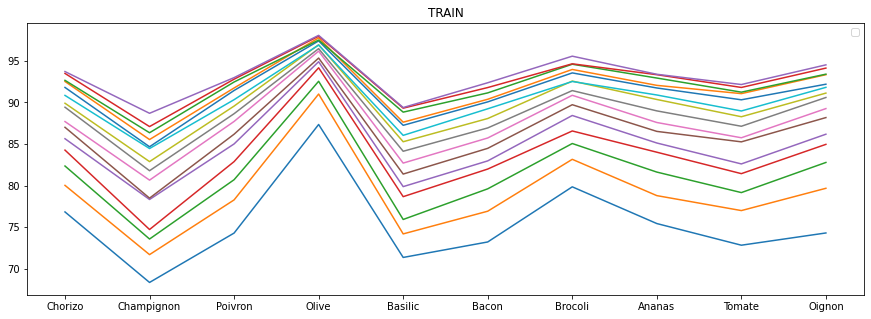

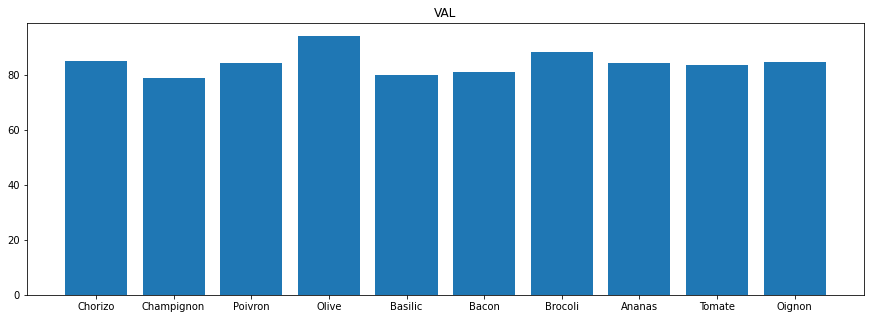

In [ ]:
plot_loss_results(train_losses, val_losses, train_perf, val_perf)

100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 122.40it/s]


Pourcentage de bonnes prédictons par topping :  [0.82293763 0.76056338 0.77464789 0.92152918 0.76257545 0.76056338
 0.80482897 0.83299799 0.78269618 0.82696177]
Moyenne des prédictions :  0.8050301810865191


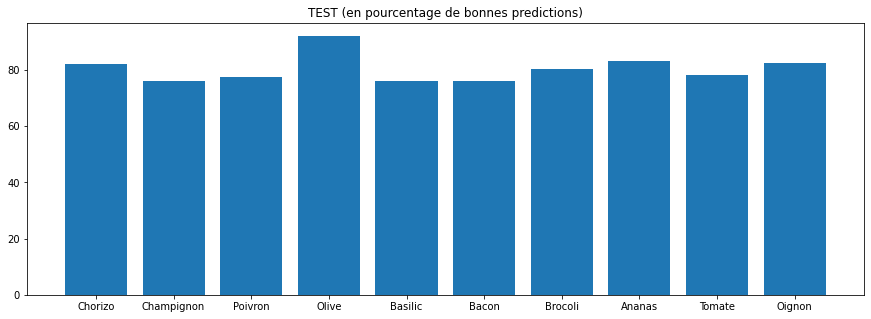

In [ ]:
Test(network, feat_testloader_ALEX)

Observations : les résultats sont proches de ceux obtenus avec un resnet. Ils ne restent néammoins pas suffisant pour qualifier notre modèle de précis.

## <font size = "7"> 4 - Fine Tuning


La principale différence avec la feature extraction est d'oppérer la backpropagation sur l'ensemble du réseau séléctionné. Les poids vont alors s'adapter parfaitement au problème qu'on souhaite résoudre.

Nous avons réalisé l'étape de fine-tuning avec le modèle préentrainé : efficientnet_b0.




### EfficientNet

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Name of the network
tag = "efficientNet"

In [ ]:
network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = network.classifier[1].in_features
network.classifier[1]= nn.Linear(num_ftrs, nlabel)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [ ]:
trainloader = train_dataloader
valloader = val_dataloader

network.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) #Adam réduit l'overfitting
lambda1 = lambda epoch: 0.97**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda1)

max_epoch = 25

learned_model, train_perf, val_perf, train_losses, val_losses = train_model_multilabel(network, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=max_epoch)
torch.save(learned_model, os.path.join(img_path, 'network_{:s}.pth'.format(tag)))

network = learned_model

Affichage des fonctions Loss (Train et Val) et résultats de Validation sur la dernière epoch :

In [ ]:
plot_loss_results(train_losses, val_losses, train_perf, val_perf)

Phase de test : 

In [ ]:
Test(network, test_dataloader)

Remarques :

C'est à ce jour, le modèle de machine learning qui nous a permis d'obtenir les meilleures performances sur les données de test sur le dataset de pizza synthétique.

- Le choix du **learning rate** s'est fait après plusieurs observations des fonctions loss. Celui choisit permet une bonne convergence de la fonction loss des données de validation sans overfiting.

- Le **scheduler** est choisi de façon à faire varier le learning rate de 0.001 à environ 0.0001 sur les 25 epochs. Ceci a permis d'accroitre la précision des prédiction sur les données de test et donc de validation.

- Le choix des 25 **epochs** s'est fait de façon a bien observer les convergences des fonctions loss d'entrainement et de validation.

- Nous n'avons pas inclu de terme de **régularisation** par manque de temps.

- Nous avons choisi l'**optimizer** Adam car il permettait de diminuer l'overfitting pafr rapport à l'optimizer Adam;

PS : Lors de la mise en commum des notebooks de chacun, nous n'avions plus accès au gpu sur tous les comptes google. Nous n'avons pas pu vérifier si le modèle fonctionne bien sur ce notebook (possible incohérence et confusion des notations avec les autres modèles). Nous avons néammoins obtenu une précision moyenne de 99,4% pour la détection des toppings sur le jeu de donné de test. Le réseau se trouve dans l'annexe avec les autres modèles, il s'appelle : *network_efficientNet.pth*


# <font size = "8"> **Conclusion**





Après les différents essais réalisés sur les différents modèles, nous nous sommes rendu compte que la méthode qui permettait d'obtenir les meilleurs résultats était le fine-tuning. Cependant elle est très couteuse en temps et en énergie car elle recalcule des millions de poids à chaque opération de backward. Nous l'avons appliqué sur l'algorithme efficientnet mais il est très probable qu'elle fonctionne également avec d'autres réseaux pré-entrainés tels que alexnet ou resnet. De plus, choisir un réseau pré-entraîné sur de la nourriture pourrait augmenter la précision des prédictions.

Nous avons également réfléchi à implémenter l'algorithme YOLO qui permet une détection efficace d'objets sur une image. Cependant, il aurait fallu retravailler l'ensemble du dataset en entourant et annotant chaque topping sur chaque image du dataset. Cela aurait pris beaucoup trop de temps et n'était pas le but de l'exercice.

Nous avons également constaté qu'un algorithme non entrainé pouvait atteindre des performances proches de 70% de précision pour chaque topping. Ceci est dû au fait que l'algorithme prédirait l'absence de tout topping sur chaque pizza. Or, cela correspond à la vérité dans 70% du dataset environ. Nous avons alors établi qu'un modèle commençait à être performant lorsqu'il dépassait les 80% de précision.
